# 7 现代卷积神经网络

## 7.1 深度卷积神经网络（AlexNet）

**特征本身应该被学习**。在合理的复杂性前提下，特征应该由多个共同学习的神经网络层组成，每个层都有可学习的参数。在机器视觉中，最底层可能检测边缘、颜色和纹理。

AlexNet的最底层学习到了一些这样的图像特征。AlexNet的更高层建立在这些底层表示的基础上，以表示更大的特征。

深度卷积神经网络的突破归结于两个因素：
- **大量**的有标签**数据**
- 通用**GPU**（general-purpose GPUs，GPGPU）的硬件实现

AlexNet 和 LeNet 的架构非常相似：

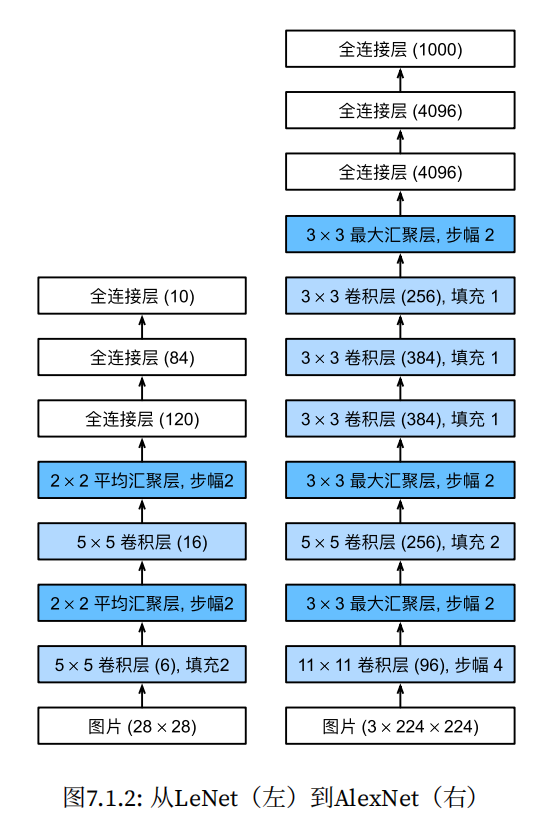

1. AlexNet 比相对较小的 LeNet5 要深得多。AlexNet 由八层组成：五个卷积层、两个全连接隐藏层和一个全连接输出层
2. AlexNet 使用 ReLU 而不是 sigmond 作为其激活函数：
- ReLU 激活函数的计算更简单
- 当使用不同参数的初始化方法时，ReLU 激活函数在正区间的梯度总是1，使得训练模型更加容易
3. AlexNet通过暂退法控制全连接层的模型复杂度，而LeNet只试用了权重衰减
4. 为了进一步扩充数据，AlexNet在训练时增加了大量的图像增强数据，如翻转、裁切和变色，这使得模型更健壮，更大的样本量有效地减少了过拟合

In [1]:
import torch
from torch import nn

net = nn.Sequential(
# 这里使用一个11*11的更大窗口来捕捉对象。
# 同时，步幅为4，以减少输出的高度和宽度。
# 另外，输出通道的数目远大于LeNet
nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
nn.MaxPool2d(kernel_size=3, stride=2),
# 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
nn.MaxPool2d(kernel_size=3, stride=2),
# 使用三个连续的卷积层和较小的卷积窗口。
# 除了最后的卷积层，输出通道的数量进一步增加。
# 在前两个卷积层之后，汇聚层不用于减少输入的高度和宽度
nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
nn.MaxPool2d(kernel_size=3, stride=2),
nn.Flatten(),
# 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过拟合
nn.Linear(6400, 4096), nn.ReLU(),
nn.Dropout(p=0.5),
nn.Linear(4096, 4096), nn.ReLU(),
nn.Dropout(p=0.5),
# 最后是输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
nn.Linear(4096, 10))

In [2]:
X = torch.randn(1, 1, 224, 224)
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

## 7.2 使用块的网络（VGG）

#### VGG 块

经典卷积神经网络的基本组成部分是如下序列：

- 带填充以保持分辨率的卷积层
- 非线性激活函数，如 ReLU
- 汇聚层，如最大汇聚层

而一个 VGG 块与之类似，由一系列卷积层组成，后面再加上用于空间下采样的最大汇聚层。

实现一个 VGG 块的样例函数：

In [ ]:
import torch
from torch import nn

def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

# 在Python中，* 操作符在函数调用时用于将列表（或元组）解包为单独的位置参数

#### VGG 网络

与 AlexNet、 LeNet 一样，VGG网络可以分为两部分：第一部分主要由卷积层和汇聚层组成，第二部分由全连接层组成。

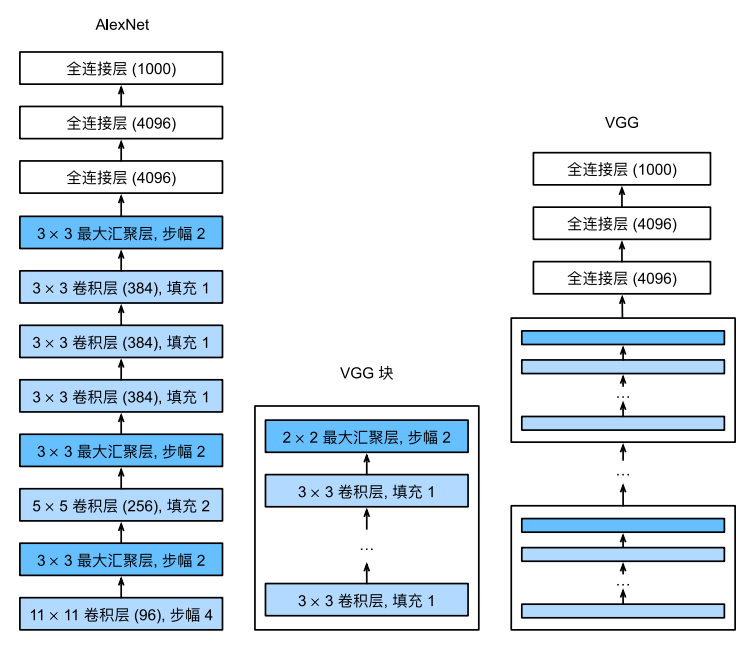

VGG 神经网络连接图中的几个VGG块，其中由超参数变量conv_arch。该变量指定了每个VGG块里卷积层个数和输出通道数。

原始VGG网络有5个卷积块，其中前两个块各有一个卷积层，后三个块各包含两个卷积层。第一个模块有64个输出通道，每个后续模块将输出通道数量翻倍，直到该数字达到512。由于该网络使用8个卷积层和三个全连接层，因此它通常被称为VGG-11。





`conv_arch` 格式：

In [1]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

实现VGG-11的函数 `vgg` ：

In [2]:
def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # 卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels
    
    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # 全连接层部分
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

## 7.3 网络中的网络（NiN）

#### 1×1卷积层

**1×1卷积层** 是一种特殊的卷积操作，它使用 1×1 大小的卷积核，对同一空间位置的所有输入通道进行线性组合，生成新的通道。它类似全连接操作，但独立应用于每个空间位置。



#### NiN块

我进行以下总结： **全连接层对应全局关系，卷积层对应空间结构信息** 。

之前的多层感知机直接将图像展平为一维向量后输入全连接层。然而，过早地使用全连接层会引发丢失空间结构信息的问题。因此使用 **1×1卷积层** 对全连接层进行代替。

NiN块以一个普通卷积层开始，后面是两个1×1的卷积层。 **这两个1×1卷积层充当带有ReLU激活函数的逐像素全连接层** 。

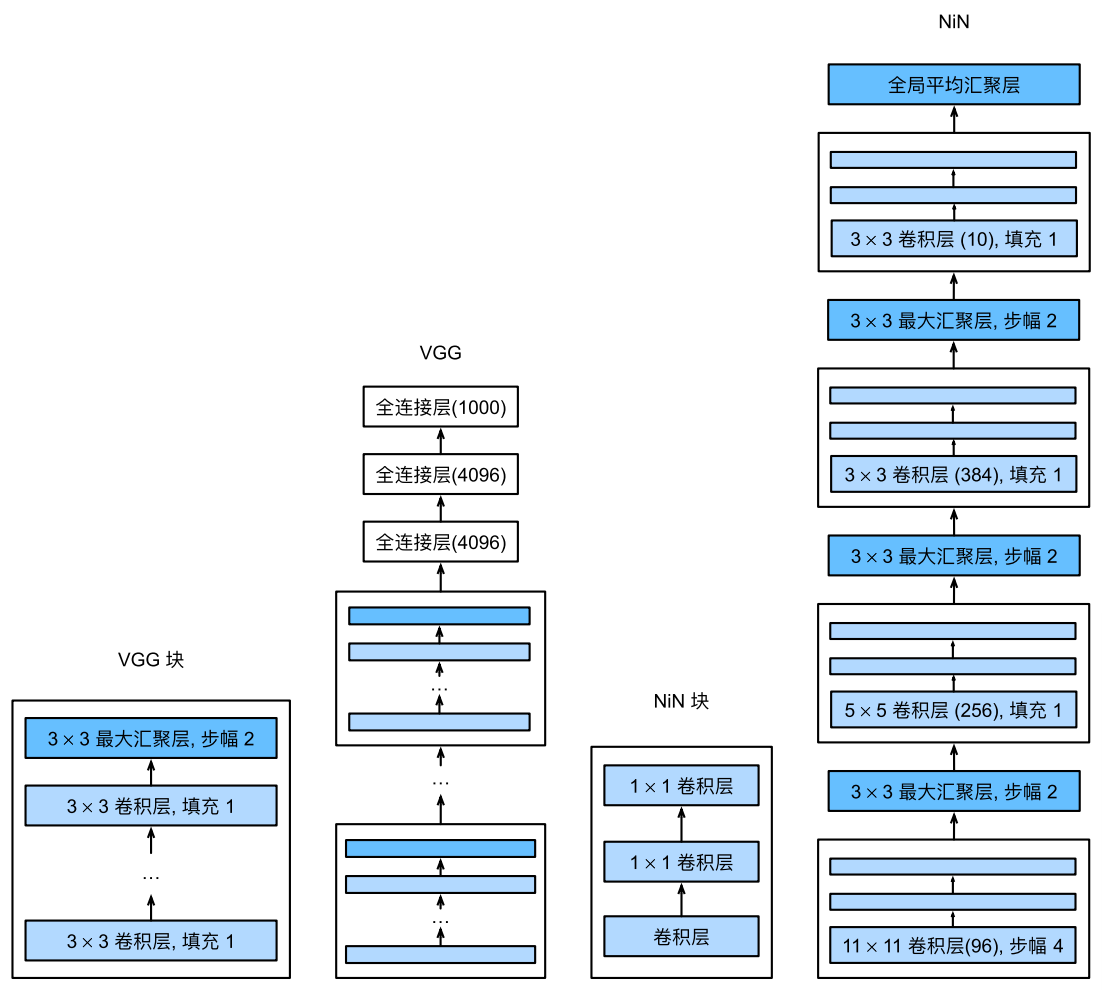

In [3]:
import torch
from torch import nn

def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU())

#### NiN模型

NiN使用窗口形状为11×11、5×5和3×3的卷积层，输出通道数量与AlexNet中的相同，每个NiN块后有一个最大汇聚层，汇聚窗口形状为3×3，步幅为2。

NiN和AlexNet之间的一个显著区别是NiN完全取消了全连接层。 **在最后，NiN使用一个NiN块，其输出通道数等于标签类别的数量，然后放一个全局平均汇聚层（global average pooling layer），生成一个对数几率（logits）** 。

In [4]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    # 标签类别数是10
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),
    # 将四维的输出转成二维的输出，其形状为(批量大小,10)
    nn.Flatten())

## 7.4 含并行连结的网络（GoogLeNet）

#### Inception块

在GoogLeNet中，基本的卷积块被称为 **Inception块（Inception block）** 。其核心思想在于使用不同滤波器（卷积层）尺寸的组合探索图像，可以有效地识别不同范围的图像的细节。

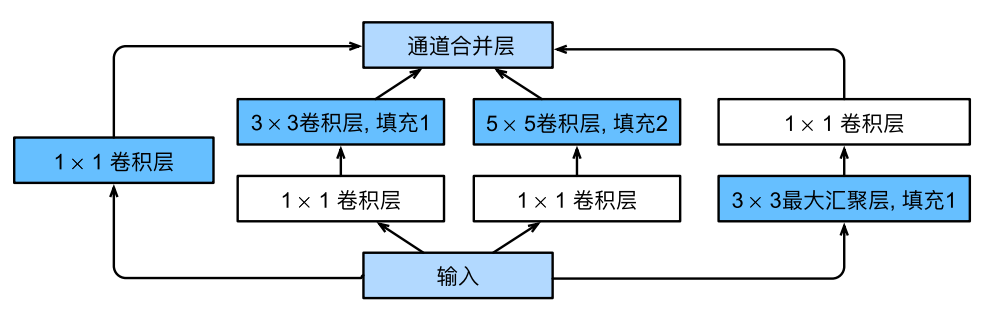

Inception块由四条并行路径组成，前三条路径使用窗口大小为 1×1、3×3、5×5 的卷积层，从不同空间大小中提取信息。中间的两条路径在输入上执行 1×1 卷积，以减少通道数，从而降低模型的复杂性。第四条路径使用 3×3 最大汇聚层，然后使用 1×1 卷积层来改变通道数。最后将每条线路的输出在通道维度上连结，并构成Inception块的输出。

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

class Inception(nn.Module):
    # c1--c4是每条路径的输出通道数
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # 线路1，单1x1卷积层
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # 线路2，1x1卷积层后接3x3卷积层
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 线路3，1x1卷积层后接5x5卷积层
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路4，3x3最大汇聚层后接1x1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # 在通道维度上连结输出
        return torch.cat((p1, p2, p3, p4), dim=1)

#### GoogLeNet模型

GoogLeNet 一共使用9个Inception块和全局平均汇聚层的堆叠来生成其估计值。

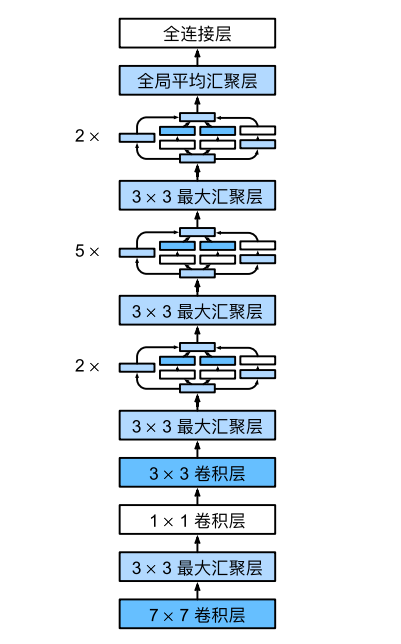

In [2]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                    nn.ReLU(),
                    nn.Conv2d(64, 192, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                    Inception(256, 128, (128, 192), (32, 96), 64),
                    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                    Inception(512, 160, (112, 224), (24, 64), 64),
                    Inception(512, 128, (128, 256), (24, 64), 64),
                    Inception(512, 112, (144, 288), (32, 64), 64),
                    Inception(528, 256, (160, 320), (32, 128), 128),
                    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                    Inception(832, 384, (192, 384), (48, 128), 128),
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

## 7.5 批量规范化

**批量规范化（batch normalization）** 是一种流行且有效的技术，可持续加速深层网络的收敛速度。

批量规范化应用于单个可选层（也可以应用到所有层），其原理如下：

- 对当前小批量数据在每个通道上计算均值和方差
- 标准化数据，将输入数据归一化为均值为0、方差为1
- 引入可学习的参数 $\gamma$ （缩放因子）和 $\beta$ （偏移因子），恢复数据的表达能力

**批量规范化层（BatchNorm层）** 在模型训练过程中，不断调整神经网络的中间输出，使整个神经网络各层的中间输出值更加稳定。其在全连接层和卷积层的使用略有不同，和暂退层一样在训练模式和预测模式下计算不同。

其实现暂不作要求。

## 7.6 残差网络（ResNet）

#### 残差块

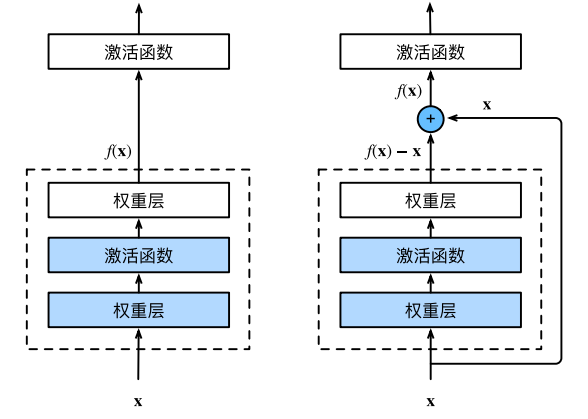

假设我们的原始输入为 $x$ ，而希望学出的理想映射为 $f(\textbf{x})$ 。左图虚线框中的部分需要直接拟合出该映射 $f(\textbf{x})$ ，而右图虚线框中的部分则需要拟合出残差映射 $f(\textbf{x})-\textbf{x}$ 。右图即为 ResNet 的基础架构： **残差块（residual block）**

将权重层替换为 卷积层 + 批量规范化层 ，使用 ReLU 作为激活函数。如果 $\textbf{x}$ 和 $f(\textbf{x})$ 的通道数不一致，则需要引入一个额外的 1×1 卷积层来将输入变换成需要的形状后再做相加运算：

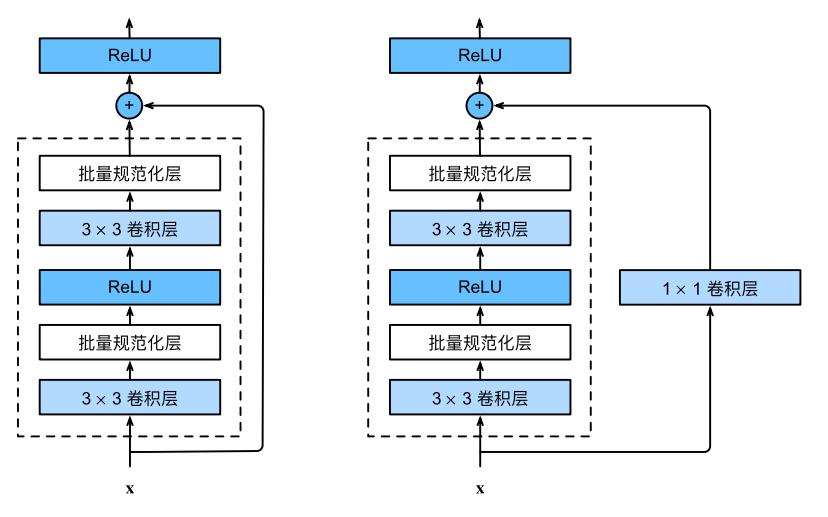

In [3]:
import torch
from torch import nn
from torch.nn import functional as F

class Residual(nn.Module): #@save
    def __init__(self, input_channels, num_channels,
                use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                                kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                                kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
    
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        return F.relu(Y + X)

#### ResNet模型

每个模块有4个卷积层（不包括恒等映射的 1×1 卷积层），加上第一个 7×7 卷积层和最后一个全连接层，共有18层。因此，这种模型通常被称为 ResNet-18。

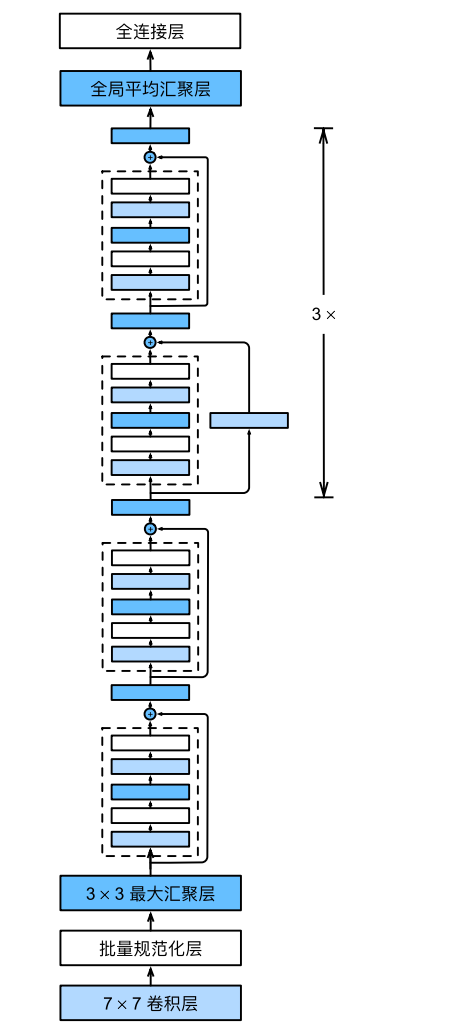

## 7.7 稠密连接网络（DenseNet）

ResNet 将函数展开为：

$$f(\textbf{x}) = \textbf{x} + g(\textbf{x})$$

即 ResNet 将 $f$ 分解为两部分：一个简单的线性项和一个复杂的非线性项。如果想将 $f$ 拓展成超过两部分的信息，则需要使用 **稠密连接网络（DenseNet）** 。

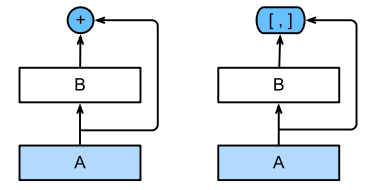

如图所示，ResNet 和 DenseNet 的关键区别在于， **在跨层连接上，DenseNet的输出是连接而不是相加** 。将图中的B层看作拟合的函数 $f$ ，则有：

$$\textbf{x} \to [\textbf{x}, f_1(\textbf{x}), f_2([x, f_1(\textbf{x})]), ...]$$

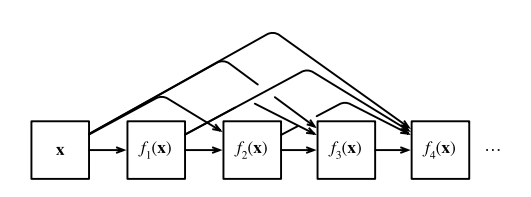

因此 **稠密连接网络的核心特点是，每一层的输入都来自前面所有层的输出在通道维度上的拼接** 。

#### 稠密块体

一个稠密块由多个卷积块组成，每个卷积块使用相同数量的输出通道。卷积块由批量规范化层（ReLU激活）、卷积层连接组成：

In [ ]:
import torch
from torch import nn

def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))

在前向传播中，将每个卷积块的输入和输出在通道维上连结：

In [ ]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(
                num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # 连接通道维度上每个块的输入和输出
            X = torch.cat((X, Y), dim=1)
        return X

#### 过渡层

过渡层是 DenseNet 中用于连接两个相邻稠密块的模块，主要作用是降低特征图的分辨率并压缩通道数，从而控制计算复杂度和内存消耗。

*我的个人理解是增加一层可训练参数量以减少整体的参数量和计算量。*

它通过 1×1 卷积层来减少通道数，并使用步幅为2的平均汇聚层减半高和宽，从而进一步降低模型复杂度。

In [ ]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

#### DenseNet 模型


DenseNet 首先使用同 ResNet 一样的单卷积层和最大汇聚层：

In [ ]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

接下来，使用 4 个稠密块：

In [ ]:
# num_channels为当前的通道数
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # 上一个稠密块的输出通道数
    num_channels += num_convs * growth_rate
    # 在稠密块之间添加一个转换层，使通道数量减半
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

最后接上全局汇聚层和全连接层来输出结果：

In [ ]:
net = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10))

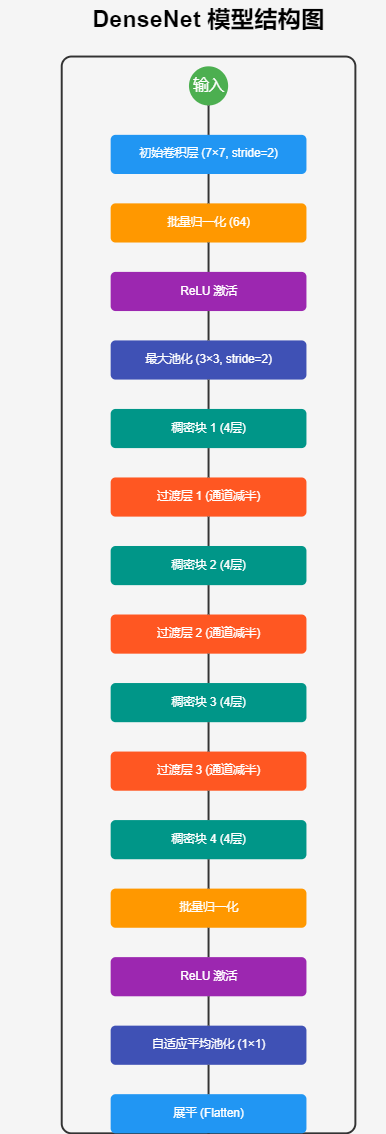